In [1]:
%load_ext autoreload

In [2]:
import math
import numpy as np

import torch
from torch import nn
from torch import distributions

import numpy as np
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tqdm.auto import trange

In [3]:
%autoreload 2
import utils
from model import SimpleNet, ModelOutput
from samplers import losses
from buffers import ReplayBuffer, LangevinReplayBuffer
from datasets_2d import DatasetSampler

In [4]:
# Fix random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For completely deterministic results - may slow down training
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Random seeds set to {SEED} for reproducibility")

Random seeds set to 42 for reproducibility


In [5]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ], device=mean.device)
    return (R @ mean.T).T


def scatter(tensor, alpha=1.0):
    plt.scatter(tensor[:, 0], tensor[:, 1], alpha=alpha)
    

def plot_trajectory(trajectory, labels: list[str] | None = None, 
                    indices: None | list = None, title: str | None = None, 
                    xlim=(-1.5, 1.5), ylim=(-1.5, 1.5)):
    if indices is not None:
        trajectory = [trajectory[i] for i in indices]
        if labels is not None:
            labels = [labels[i] for i in indices]

    figure, axes  = plt.subplots(1, len(trajectory), figsize=(4 * len(trajectory), 4))
    if title is not None:
        figure.suptitle(title)
    
    for i, sample in enumerate(trajectory):
        title = labels[i] if labels is not None else f'iter {i}'
        
        axes[i].set_title(title)
        axes[i].scatter(sample[:, 0], sample[:, 1]) 
        axes[i].set_xlim(*xlim)
        axes[i].set_ylim(*ylim)
    
    return figure

@torch.no_grad()
def draw_level_lines(func, samples=None, lims=(-2, 2), nsamples: int = 100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)  # Shape: [100, 100, 2]

    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    Z = func(grid_points).numpy()  # Shape: [100, 100]
    Z = Z.reshape(nsamples, nsamples).T

    plt.figure()
    contour = plt.contour(X, Y, Z, levels=7, colors='k')  # Draw contour lines
    plt.clabel(contour, inline=True, fontsize=6)           # Add labels to contours
    plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)       # Filled contours for visualization
    if samples is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c='r')
    plt.colorbar(label='Function Value')                  # Add color bar
    plt.title('Level Lines of the Function')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


def get_drid(lims=(-5, 5), nsamples=100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)
    return torch.from_numpy(grid_points).reshape(-1, 2).float()

In [6]:
alpha = 4.0
gamma = 0.012
t_max = 0.024
n_steps = 20


def ref_process(x, t):
    return ModelOutput(drift=alpha * x)


def get_mean_log_var(model, x, t, dt):
    log_var = torch.as_tensor(2.0 * dt, device=x.device).log()
    output = model(x, t)
    
    if output.contains('log_var'):
        log_var = log_var + output.log_var
    
    mean = x + output.drift * dt
    return mean, log_var


def make_euler_maruyama_step(model, x, t, dt):
    mean, log_var = get_mean_log_var(model, x, t, dt)
    return mean + torch.randn_like(mean) * log_var.exp().sqrt()


def log_normal_density(x, mean, log_var):
    return - 0.5 * (log_var + torch.exp(- log_var) * (x - mean).pow(2)).sum(-1)


def sample_trajectory(model, x_start, direction, dt, n_steps, t_max, 
                      only_last: bool = False, return_timesteps: bool = False):
    assert direction in {"forward", "backward"}
    trajectory, timesteps = [x_start], [f"timestep {t_max if direction == 'backward' else 0}"]
    
    for t_step in (
            torch.linspace(dt, t_max, n_steps).flip(-1) \
            if direction == 'backward' \
            else torch.linspace(0, t_max - dt, n_steps)
        ):
        shift = - dt if direction == "backward" else + dt
        timesteps.append(f"timestep {t_step.item() + shift:.3f}")
        
        t = torch.ones(x_start.size(0)) * t_step
        trajectory.append(make_euler_maruyama_step(model, trajectory[-1], t, dt))
    
    if return_timesteps:
        return trajectory, timesteps
    
    if only_last:
        return trajectory[-1]
    
    return trajectory

In [7]:
class GaussMix:
    def __init__(self, means, sigmas):
        mix = distributions.Categorical(torch.ones(means.size(0), device=means.device))
        comp = distributions.Independent(distributions.Normal(means, sigmas), 1)
        self.gmm = distributions.MixtureSameFamily(mix, comp)

        self._grad = torch.func.grad(lambda y: self.log_prob(y).sum())

    def  to(self, device='cpu'):
        self.gmm.to(device)

    def log_prob(self, x):
        return self.gmm.log_prob(x)
    
    def grad(self, x):
        return self._grad(x)

In [8]:
def add_uniform_circular_noise(size, max_radius, device='cpu'):
    radius = torch.rand(size, device=device) * max_radius
    angle = torch.rand(size, device=device) * 2 * math.pi
    return torch.stack([torch.cos(angle), torch.sin(angle)], dim=-1) * radius.view(-1, 1)

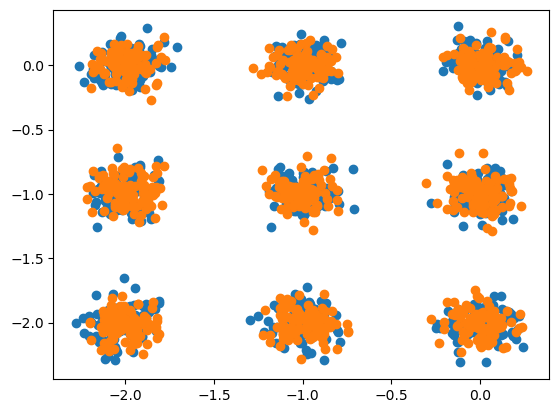

In [9]:
grid = torch.arange(3) - 2

means = torch.cat([
    grid.view(-1, 1).repeat(1, 3).view(3, 3, 1), 
    grid.view(1, -1).repeat(3, 1).view(3, 3, 1)], 
dim=-1).reshape(9, 2)
sigmas = torch.ones_like(means) * 0.1

log_p_1 = GaussMix(means, sigmas)
logp_enegy = lambda x: - log_p_1.log_prob(x)

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[means, sigmas],
    p_1='mix_of_gaussians', p_1_args=[means, sigmas],
)

x_0, x_1 = sampler.sample(900)

scatter(x_0)
scatter(x_1)

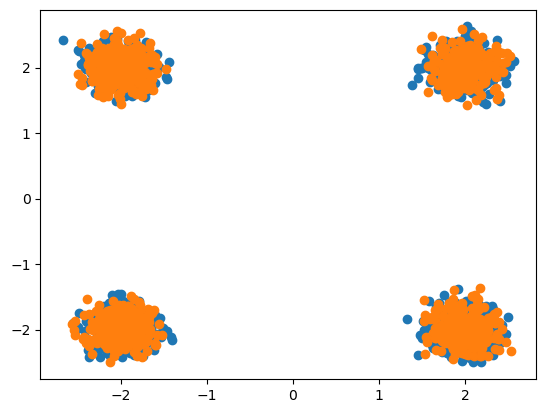

In [10]:
means2 = torch.tensor([[-2, 2], [2, 2],
                    #    [-3, 0], [3, 0],
                    #    [0, -3], [0, 3],
                       [-2, -2], [2, -2]]
                       ).float() * 1.0

sigmas2 = torch.ones_like(means2) * 0.2

log_p_1 = GaussMix(means2, sigmas2)
logp_enegy = lambda x: - log_p_1.log_prob(x)

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[means2, sigmas2],
    p_1='mix_of_gaussians', p_1_args=[means2, sigmas2],
)

x_0, x_1 = sampler.sample(128 * 9)

scatter(x_0)
scatter(x_1)

True 0.4


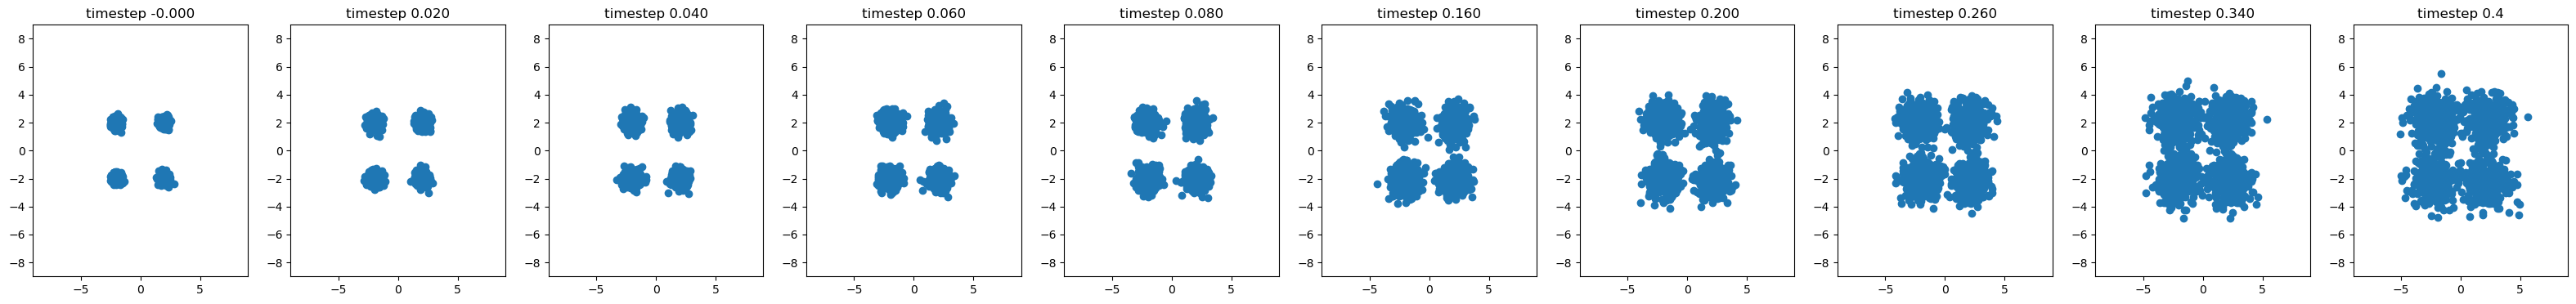

In [11]:
alpha = 0.23
gamma = 0.02
t_max = 0.4
n_steps = 20

print(gamma * n_steps == t_max, gamma * n_steps)

x_0, _ = sampler.sample(128 * 9 )
trajectory, timesteps = sample_trajectory(ref_process, x_0, 'backward', gamma, 
                                          n_steps, t_max, return_timesteps=True)

_ = plot_trajectory(trajectory, timesteps[::-1], indices=[0, 1, 2, 3, 4, 8, 10, -8, -4, -1],
                    xlim=(-9, 9), ylim=(-9, 9))

In [35]:
DEVICE = "cpu"
N_SB_STEPS = 1000
N_MAX_ITER = 6_000
PREDICT_LOGVAR = True
BATCH_SIZE = 512
N_TRAJECTORIES = 2

fwd_model = SimpleNet(64, 64, n_main_body_layers=3, 
                      predict_log_var=PREDICT_LOGVAR).to(DEVICE)
bwd_model = SimpleNet(64, 64, n_main_body_layers=3, 
                      predict_log_var=PREDICT_LOGVAR).to(DEVICE)

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), 
            nn.LayerNorm(dim), 
            nn.ELU()
        )
    
    def forward(self, x):
        return x + self.block(x)


class Energy(nn.Module):
    def __init__(self):
        super().__init__()

        # self.net = nn.Sequential(
        #     nn.Linear(2, 256), nn.ELU(),
        #     nn.Linear(256, 256), nn.LayerNorm(256), nn.ELU(),
        #     nn.Linear(256, 256), nn.LayerNorm(256), nn.ELU(),
        #     nn.Linear(256, 256), nn.LayerNorm(256), nn.ELU(),
        #     nn.Linear(256, 256), nn.LayerNorm(256), nn.ELU(),
        #     nn.Linear(256, 1)
        # )
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.ELU(),
            # nn.Linear(64, 64), nn.LayerNorm(64), nn.ELU(),
            # nn.Linear(64, 64), nn.LayerNorm(64), nn.ELU(),
            # nn.Linear(64, 64), nn.LayerNorm(64), nn.ELU(),
            nn.Linear(64, 64), nn.LayerNorm(64), nn.ELU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out = self.net(x)
        # return out.squeeze(1)
        # x_pow_2 = x.pow(2).sum(dim=1, keepdim=True)
        # out = x_pow_2 + out
        return out.squeeze(1)

        # if out.size(1) == 2:
        #     pow_coeff = nn.functional.softplus(out[:, :1])
        #     x_pow_2 = x_pow_2 * pow_coeff
        #     out = out[:, 1:]



energy = Energy()

ebm_log_dencity = lambda x: - energy(x)
BIG_X_0, _ = sampler.sample(512 * 9)

fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=1e-4)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=5e-4)

energy_optim = torch.optim.Adam(energy.parameters(), lr=3e-4)

fwd_ema_loss = utils.EMALoss(0.1)
bwd_ema_loss = utils.EMALoss(0.1)

# p1_buffer = LangevinReplayBuffer(2048, log_p_1.grad, 0.01, 200)
p1_buffer = ReplayBuffer(2048)

In [36]:
def ebm_loss(energy_model, positive_samples, negative_samples, alpha=1.0):
    positive_energy = energy_model(positive_samples).mean()
    negative_energy = energy_model(negative_samples).mean()
    
    regularization = alpha * (positive_energy**2 + negative_energy**2)
    return positive_energy - negative_energy + regularization

2800


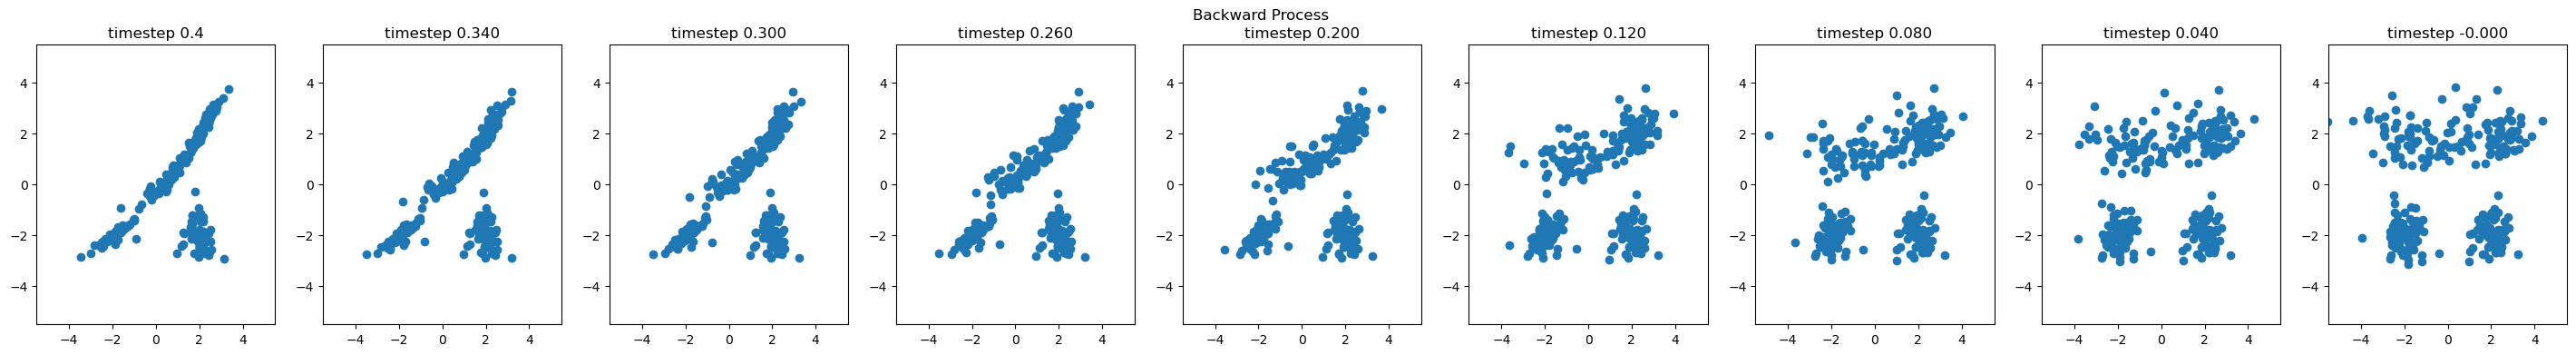

AssertionError: forward loss is NaN

In [37]:
SEED = 3754
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For completely deterministic results - may slow down training
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


for it in range(10_000):
    # BACKWARD PROCESS
    num_bwd_iters = 1
    num_fwd_iters = 1
    num_energy_iters = 1

    pbar = trange(num_bwd_iters, leave=False, desc=f'It {it} | Backward') if num_bwd_iters > 10 else range(num_bwd_iters)
    for _ in pbar:
        bwd_optim.zero_grad(set_to_none=True)

        # x_0, _ = sampler.sample(BATCH_SIZE)
        indices = torch.randperm(512 * 9)[:BATCH_SIZE]
        x_0 = BIG_X_0[indices]
        x_0 = x_0 + torch.randn_like(x_0) * 0.5

        _fwd_model = ref_process if it == 0 else fwd_model
        traj_loss = losses.compute_bwd_tlm_loss(_fwd_model, bwd_model, x_0, 
                                                gamma, t_max, n_steps)
        assert not torch.isnan(traj_loss).any(), "backward loss is NaN"
        
        bwd_optim.step()
        bwd_ema_loss.update(traj_loss.item() / n_steps)

    if it % 100 == 0:
        clear_output(wait=True)
        print(it)
        with torch.no_grad():
            x_0, _ = sampler.sample(BATCH_SIZE // N_TRAJECTORIES)
            x_0 = x_0 + torch.randn_like(x_0) * 0.5
            
            _fwd_model = ref_process if it == 0 else fwd_model
            fwd_trajectory, timesteps = sample_trajectory(_fwd_model, x_0, "forward", gamma, 
                                                        n_steps, t_max, return_timesteps=True)
            bwd_trajectory, timesteps = sample_trajectory(bwd_model, fwd_trajectory[-1], "backward", gamma, 
                                                n_steps, t_max, return_timesteps=True)
        
        fig_bwd = plot_trajectory(bwd_trajectory, timesteps, 
                                  indices=[0, 3, 5, 7, 10, -7, -5, -3, -1],
                                  title="Backward Process" ,
                                  xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))
        # fig_bwd.show()
        plt.show()

    # FORWARD PROCESS
    pbar = trange(num_fwd_iters, leave=False, desc=f'It {it} | Forward') if num_fwd_iters > 10 else range(num_fwd_iters)
    for _ in pbar:
        fwd_optim.zero_grad(set_to_none=True)

        if True: #it == 0:
            indices = torch.randperm(512 * 9)[:BATCH_SIZE // N_TRAJECTORIES]
            x_0 = BIG_X_0[indices]
        else:
            x_1_buffer = p1_buffer.sample(BATCH_SIZE // N_TRAJECTORIES)
            with torch.no_grad():
                x_0 = sample_trajectory(bwd_model, x_1_buffer, "backward", gamma,
                                        n_steps, t_max, only_last=True)
            # Try the following backward trajectory:
            # take samples from dataset as if they are from energy 
            # sample backward trajectory from them and then train forward model on it
            
        x_0 = x_0.repeat(N_TRAJECTORIES, 1)
        x_0 = x_0 + torch.randn_like(x_0) * 0.5
        loss = losses.compute_fwd_vargrad_loss(fwd_model, bwd_model, 
                                            #    log_p_1.log_prob,
                                               ebm_log_dencity,
                                               x_0, gamma, t_max, n_steps, 
                                               p1_buffer=p1_buffer, 
                                               n_trajectories=N_TRAJECTORIES)
        assert not torch.isnan(loss).any(), "forward loss is NaN"

        loss.backward()
        fwd_optim.step()

        fwd_ema_loss.update(loss.mean().item() / n_steps)

    if it % 100 == 0:
        with torch.no_grad():
            x_0, _ = sampler.sample(BATCH_SIZE // N_TRAJECTORIES)
            x_0 = x_0 + torch.randn_like(x_0) * 0.5
            fwd_trajectory, timesteps = sample_trajectory(fwd_model, x_0, "forward", gamma, 
                                                        n_steps, t_max, return_timesteps=True)
        
        fig_fwd = plot_trajectory(fwd_trajectory, timesteps, 
                            indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], 
                            title="Forward Process", xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))
        # fig_fwd.show()
        plt.show()

    pbar = trange(num_energy_iters, leave=False, desc=f'It {it} | Energy') if num_energy_iters > 10 else range(num_energy_iters)
    for i in pbar:
        with torch.no_grad():
            indices = torch.randperm(1024)[:BATCH_SIZE // N_TRAJECTORIES]
            x_0 = BIG_X_0[indices]
            x_00 = x_0 + torch.randn_like(x_0) * 0.5

            x_1 = sample_trajectory(fwd_model, x_00, "forward", gamma, 
                                    n_steps, t_max, only_last=True)
        
        energy_optim.zero_grad(set_to_none=True)
        loss = ebm_loss(energy, x_0, x_1, alpha=0.0)
        assert not torch.isnan(loss).any(), "energy loss is NaN"
        loss.backward()
        energy_optim.step()
    
        if it % 100 == 0:
            limits = (-15, 15)
            print(f'Energy Loss: {loss.item()}')
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Scatter plot of samples from x_1
            axes[0].scatter(x_1[:, 0], x_1[:, 1], c='r', alpha=0.5)
            axes[0].set_title('Samples from x_1')
            axes[0].set_xlim(*limits)
            axes[0].set_ylim(*limits)

            # Energy function plot
            x = np.linspace(*limits, 200)
            y = np.linspace(*limits, 200)
            X, Y = np.meshgrid(x, y)
            grid_points = np.stack([X, Y], axis=-1)
            grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
            log_density = ebm_log_dencity(grid_points).detach()
            log_density = log_density - log_density.max() 

            Z = log_density.numpy().reshape(200, 200).T

            contour = axes[1].contour(X, Y, Z, levels=7, colors='k')
            axes[1].clabel(contour, inline=True, fontsize=6)
            axes[1].contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)
            axes[1].set_title('Energy Function')
            axes[1].set_xlim(*limits)
            axes[1].set_ylim(*limits)
            fig.colorbar(axes[1].contourf(X, Y, Z, levels=10, cmap='viridis', 
                                          alpha=0.5), ax=axes[1], label='Energy Value')

            plt.show()

Sampling from the enegy

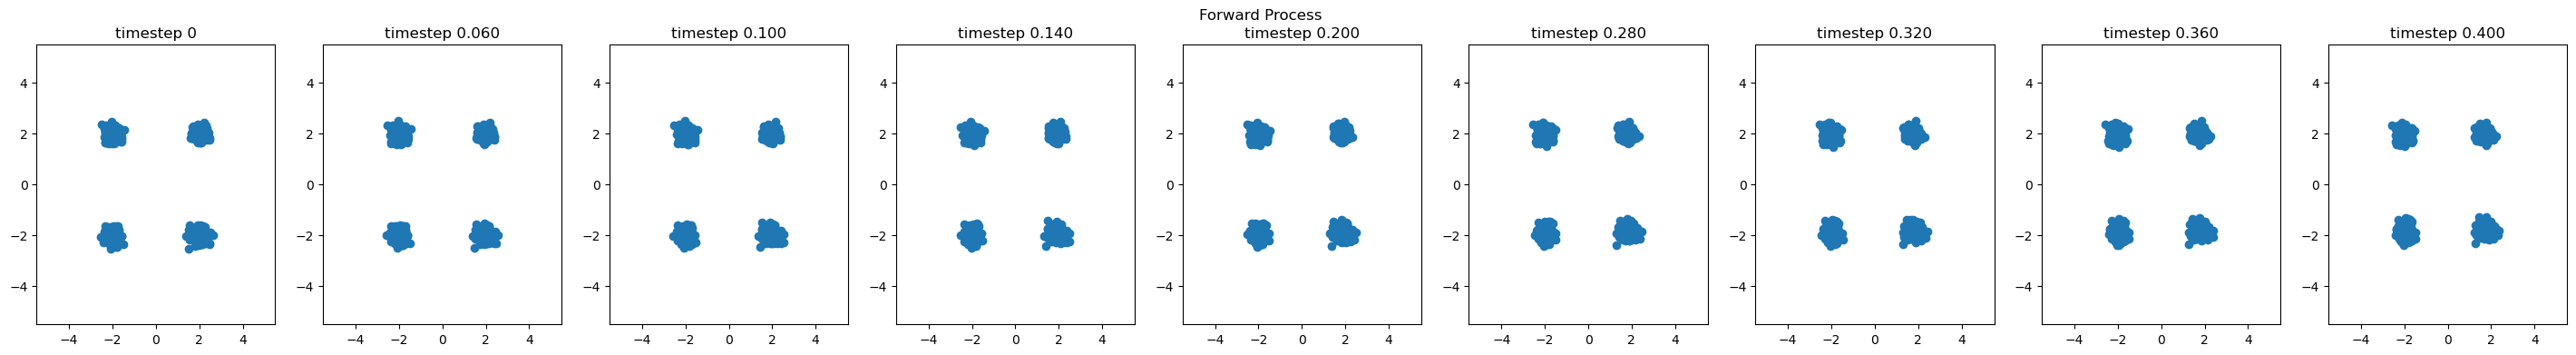

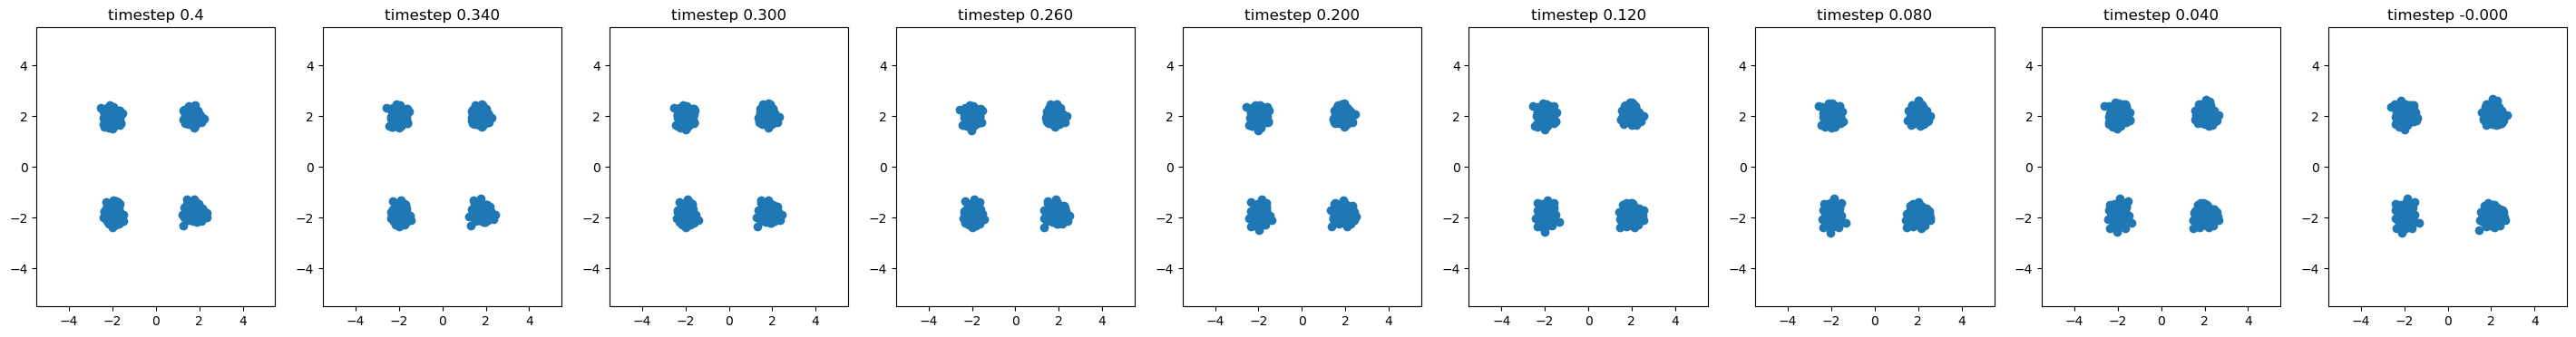

In [46]:
x_0, x_1 = sampler.sample(512)

with torch.no_grad():
    fwd_trajectory, timesteps = sample_trajectory(fwd_model, x_0, "forward", gamma, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(fwd_trajectory, timesteps, 
                    indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title="Forward Process",
                    xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))

with torch.no_grad():
    bwd_trajectory, timesteps = sample_trajectory(bwd_model, fwd_trajectory[-1], "backward", gamma, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(bwd_trajectory, timesteps, indices=[0, 3, 5, 7, 10, -7, -5, -3, -1],
                    xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))

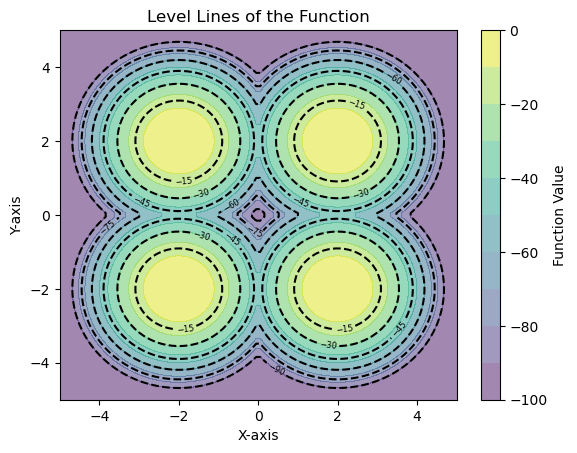

In [47]:


with torch.no_grad():
    draw_level_lines(lambda x: log_p_1.log_prob(x).clamp(-100, None), lims=(-5, 5))

Run langevin dynamics

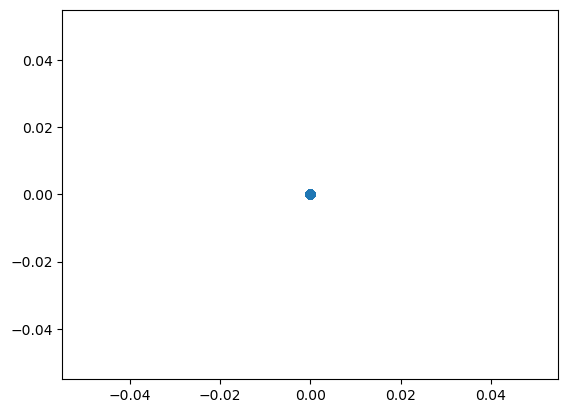

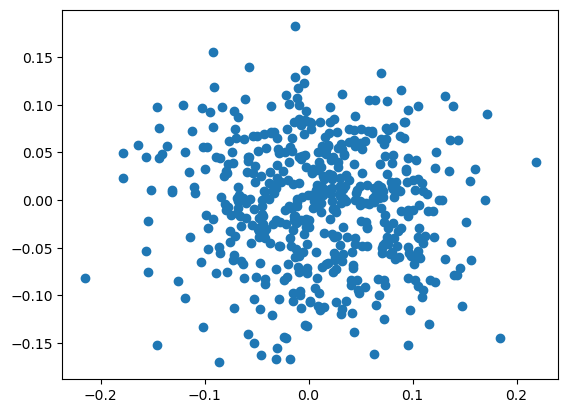

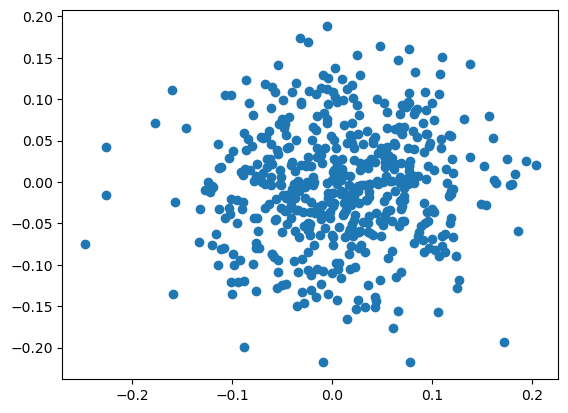

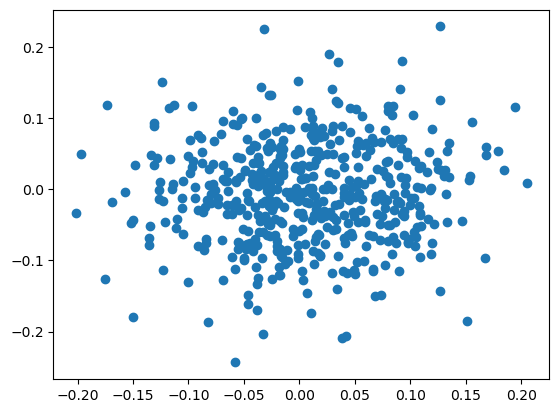

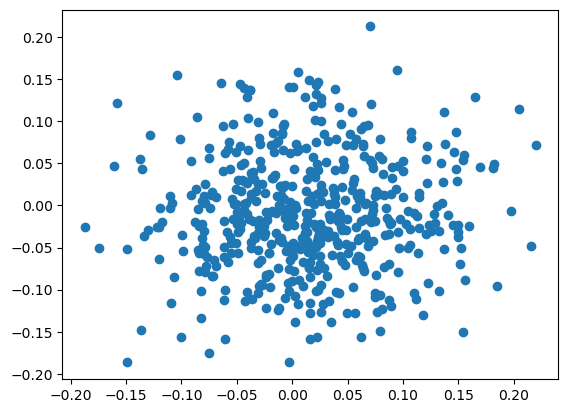

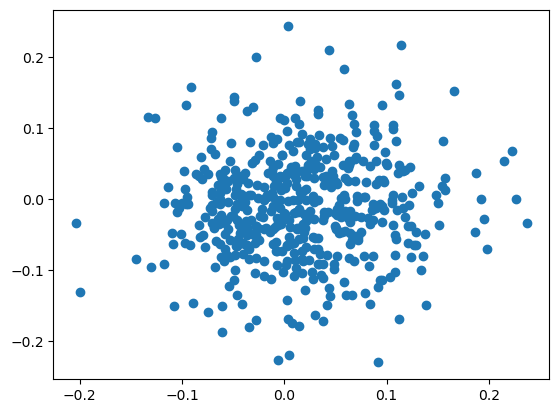

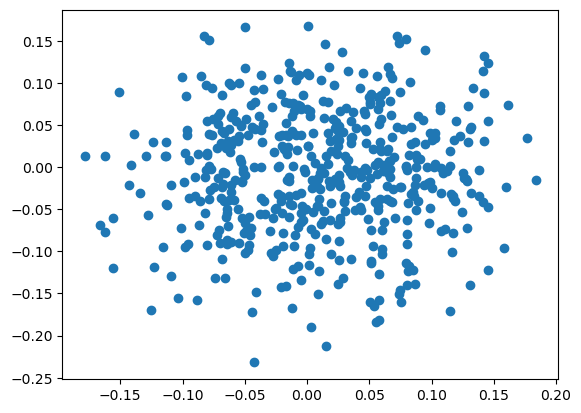

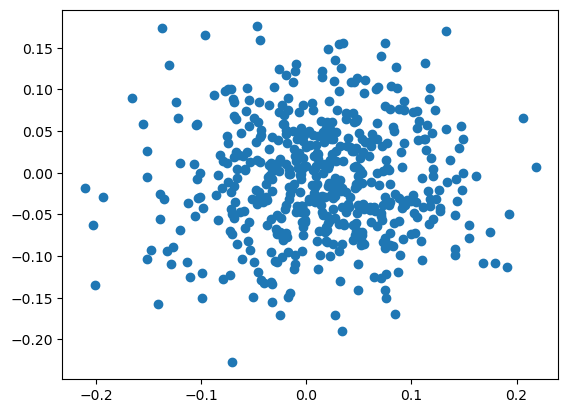

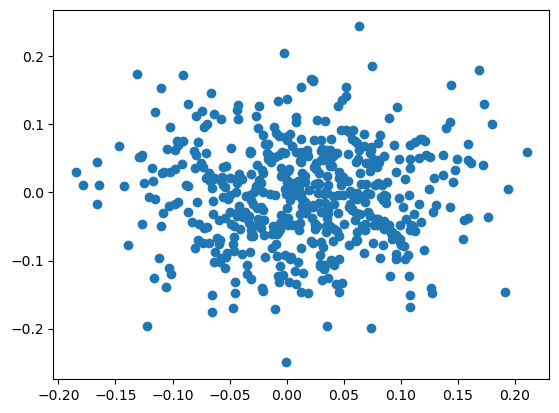

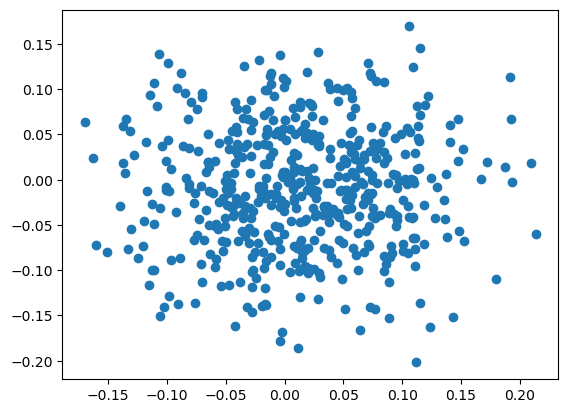

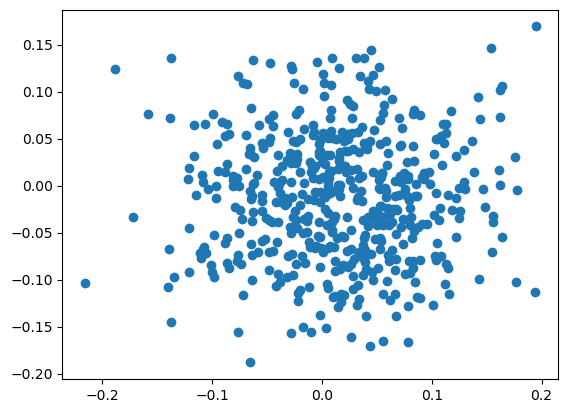

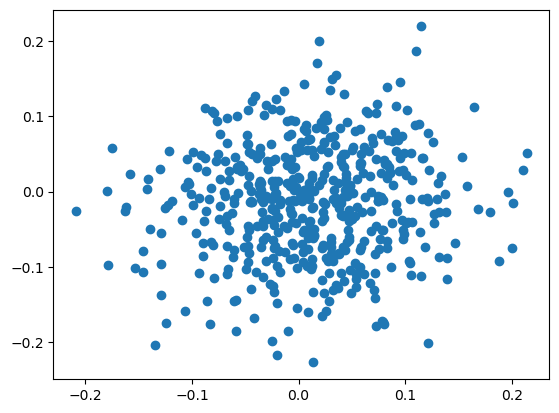

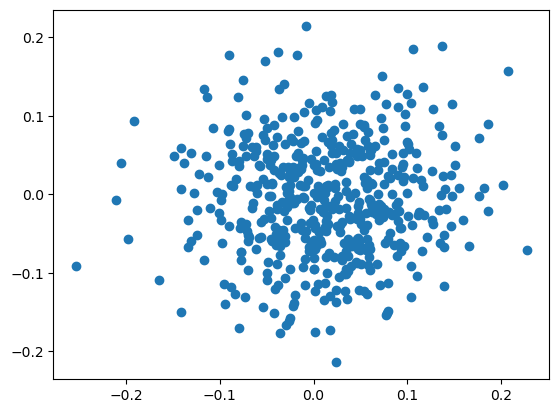

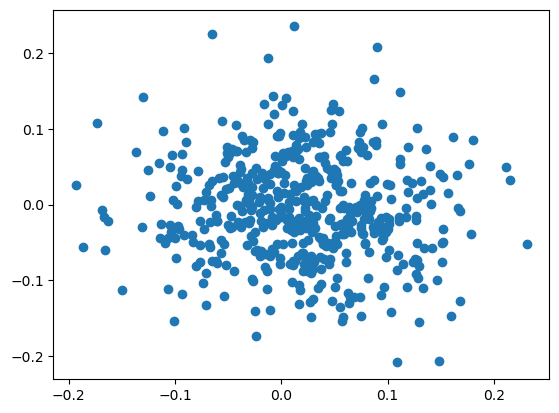

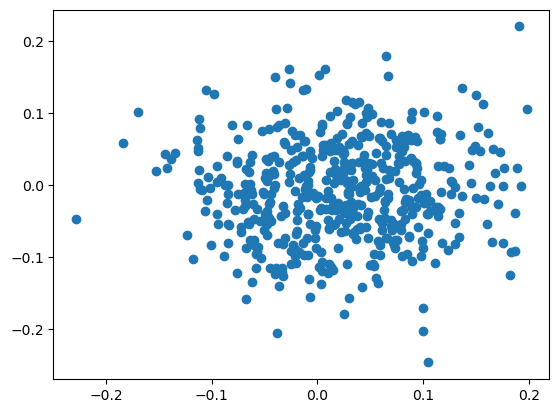

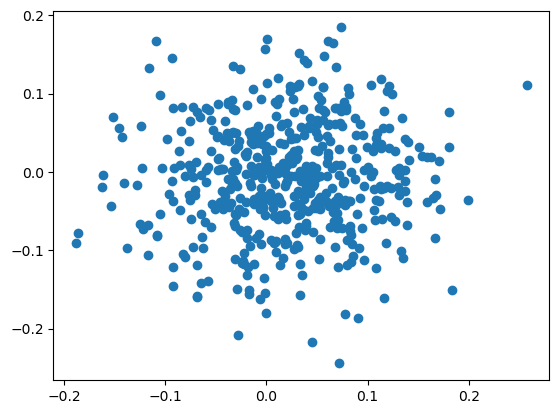

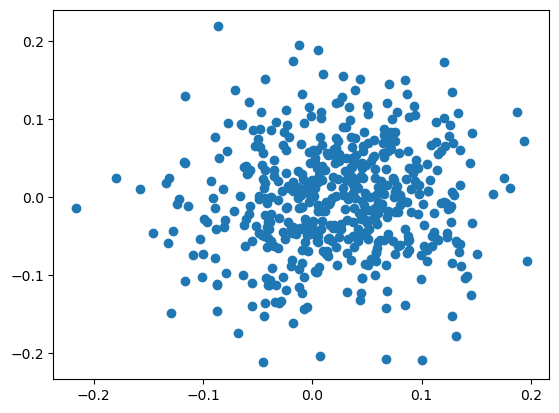

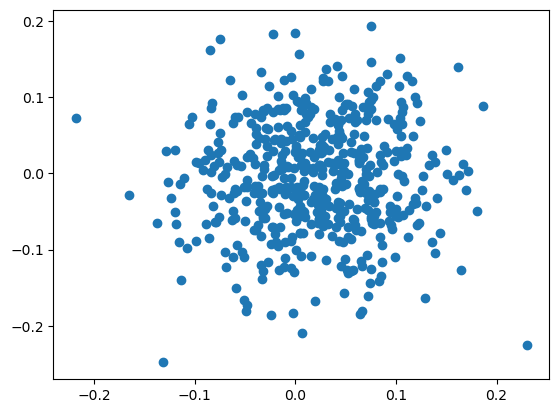

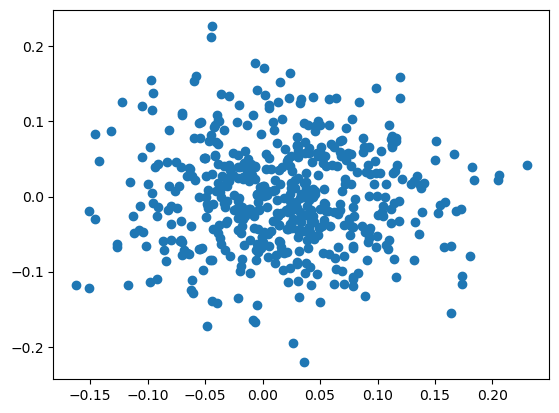

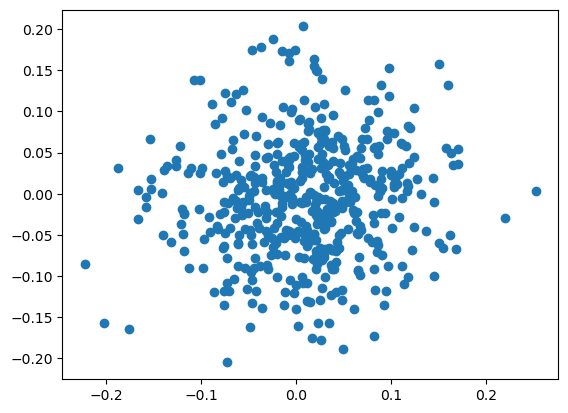

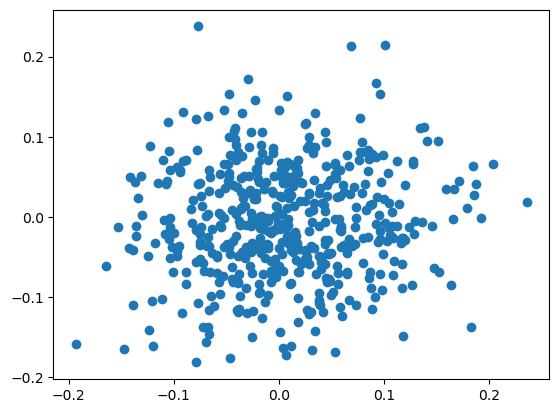

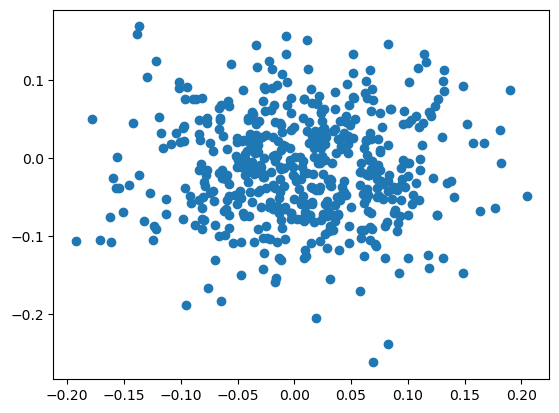

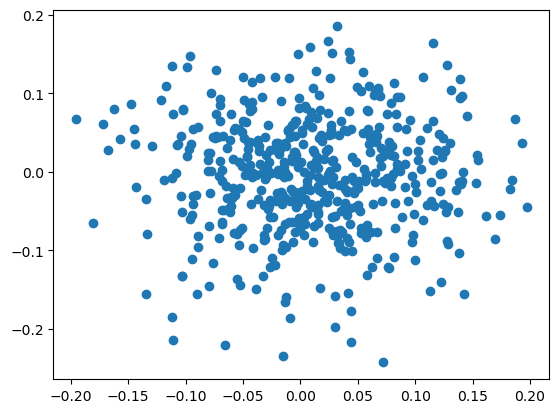

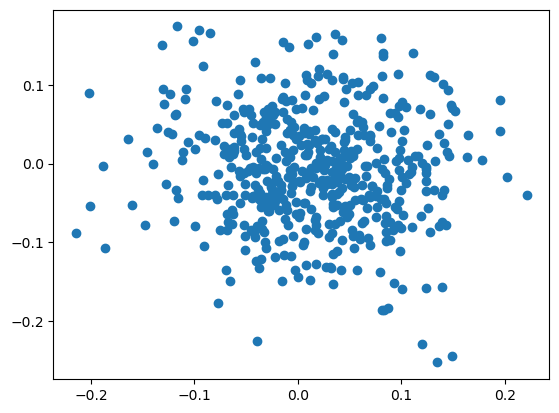

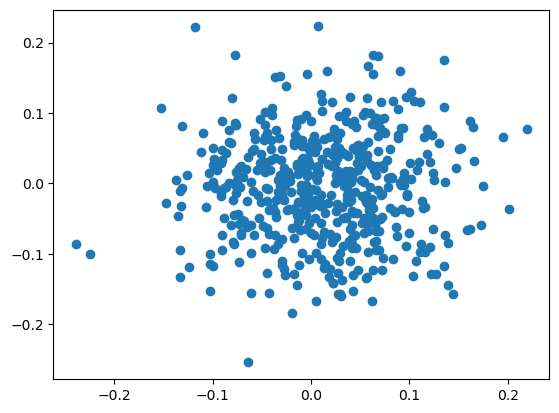

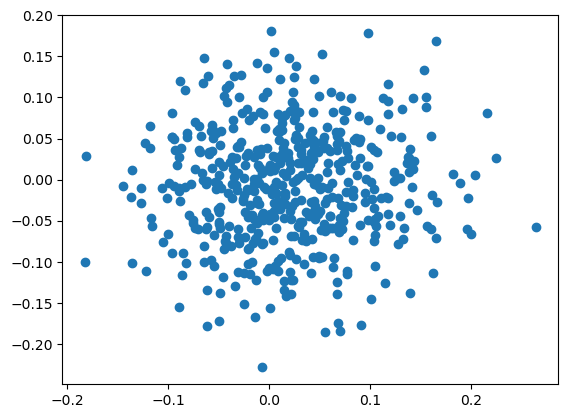

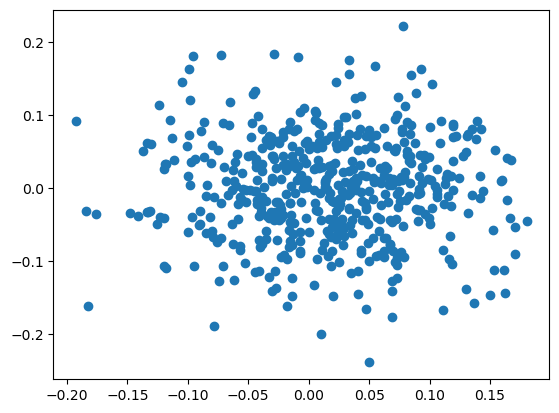

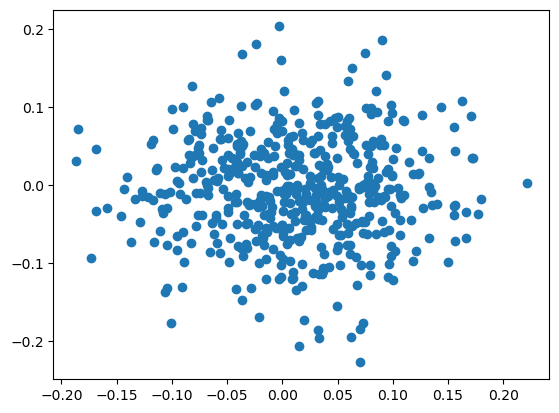

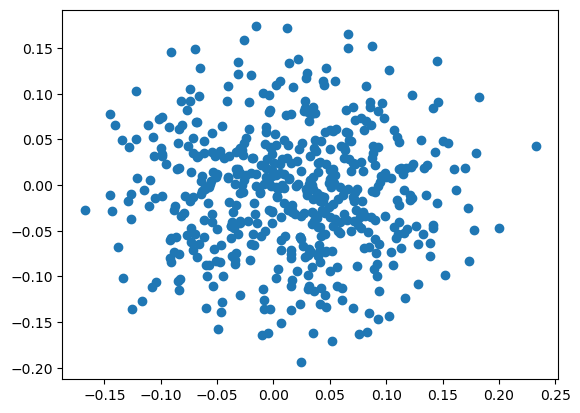

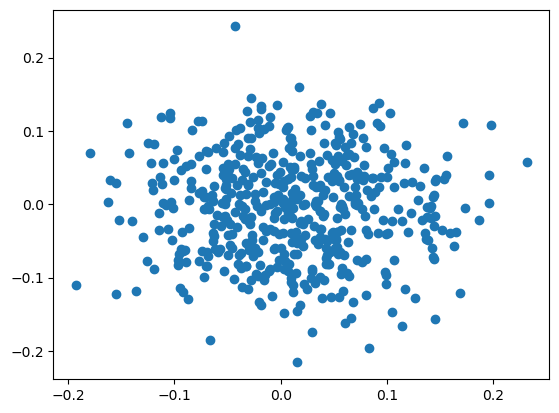

In [63]:
step_size = 0.01
x = torch.zeros(512, 2)


for i in range(3000):
    if i % 100 == 0:
        scatter(x.detach())
        plt.show()
    
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    x = x - 0.5 * step_size * grad + torch.randn_like(x) * step_size
    
